In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [2]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [3]:
choppeddata=pd.read_csv('choppeddata_9_21_2021.csv')#.head()

choppedheaders=[]
lookback=11 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((96,5,11)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((96,11)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,575,6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
print(Labels[:,10]) #just getting finals labels

[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
j = np.array([[ 0,  1,  2],
              [ 3,  4,  5],
              [ 6,  7,  8],
              [ 9, 10, 11]])
print(j)
print(j.shape)
print(j[:,2])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
(4, 3)
[ 2  5  8 11]


In [5]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State
y=Labels[:,10]
print(X.shape)

y=y.reshape(96,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)
print("Train")
print(train_x[0])
print(train_y.size)
print("Test")
print(test_x[0])
print(test_y[0])


(96, 5, 11)
Train
[[0.66067274 0.70430639 0.67520184 0.68615223 0.67641444 0.68186801
  0.6758689  0.68460397 0.68511599 0.70822891 0.72352148]
 [0.59001962 0.57353245 0.60273334 0.61739001 0.59798504 0.60680647
  0.59784728 0.59608482 0.60003762 0.60154628 0.58328973]
 [0.86593884 0.83491177 0.94853401 0.93162722 0.9459562  0.93877476
  0.94461182 0.93864763 0.94677179 0.92434139 0.93277732]
 [0.42719015 0.44386521 0.42301241 0.40947675 0.42378999 0.42103409
  0.42091323 0.42617751 0.42432461 0.41765465 0.43021535]
 [0.68492613 0.73713396 0.71732474 0.72483717 0.72541902 0.72632117
  0.72377245 0.73094436 0.72926961 0.74526455 0.75568234]]
72
Test
[[0.50901364 0.53791286 0.51748383 0.53651339 0.53188663 0.52694585
  0.5205152  0.51844995 0.53539513 0.53282207 0.51940971]
 [0.45338884 0.47082336 0.46394748 0.44508077 0.45347655 0.42774596
  0.44400104 0.43419636 0.42854116 0.42113377 0.43428465]
 [0.87219985 0.94368344 0.93634421 0.94400243 0.93876059 0.93731456
  0.94509448 0.94018378

In [6]:
print(train_x.shape)  #example was (980185, 90, 5)

(72, 5, 11)


We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

In [7]:
batch_size = 8
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


In [8]:
print(train_loader)

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [9]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cpu


In [11]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=500, model_type="GRU"):
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%20 == 0:
            print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        
            print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE                               

Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 20/500 Done, Total Loss: 0.22824055949846903
Total Time Elapsed: 0.42497700000000016 seconds
Epoch 40/500 Done, Total Loss: 0.19123266554541057
Total Time Elapsed: 0.4442619999999984 seconds
Epoch 60/500 Done, Total Loss: 0.17814971009890238
Total Time Elapsed: 0.4034720000000007 seconds
Epoch 80/500 Done, Total Loss: 0.1593889743089676
Total Time Elapsed: 0.6687569999999994 seconds
Epoch 100/500 Done, Total Loss: 0.15321586115492714
Total Time Elapsed: 0.42043499999999767 seconds
Epoch 120/500 Done, Total Loss: 0.14536812322007286
Total Time Elapsed: 0.4496299999999991 seconds
Epoch 140/500 Done, Total Loss: 0.12950144045882755
Total Time Elapsed: 0.4932539999999932 seconds
Epoch 160/500 Done, Total Loss: 0.12104778985182445
Total Time Elapsed: 0.5323429999999973 seconds
Epoch 180/500 Done, Total Loss: 0.09544661061631309
Total Time Elapsed: 0.4245559999999955 seconds
Epoch 200/500 Done, Total Loss: 0.10965718825658162
Total Time Elapsed: 0.540645000000012 seconds
Epoch 220/500 

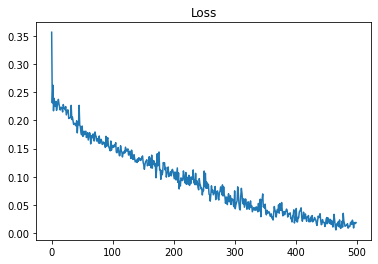

In [12]:
lr = 0.001#0.001
gru_model = train(train_loader, lr, model_type="GRU")

#The target size means the label size!

In [37]:
model=gru_model
i=1
inp = torch.from_numpy(np.array(test_x))
labs = torch.from_numpy(np.array(test_y))
#h = model.init_hidden(inp.shape[0])
h = model.init_hidden(inp.shape[0])
#print("inp",inp)

#print("INP SHAPE",inp.shape)
#print("INP SHAPE[0]",inp.shape[0])
#print("labs",labs)
#print("h",h)
#print("h.shape",h.shape)
#print(inp.to(device).float())
#print(inp.to(device).float().shape)
print(inp.to(device).float().shape)

out, h = model(inp.to(device).float(), h)
#print(out)

RuntimeError: CUDA error: unspecified launch failure

In [26]:
#gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
#print(test_y)
print(gru_outputs)
print(gru_outputs[0][5])

Evaluation Time: 0.022149999999999892
sMAPE: 1.055325718671533%
[array([-7.3618658e-02,  9.8243004e-01,  9.6595168e-01,  9.7385561e-01,
       -1.0710596e-01,  9.7495830e-01,  1.0029546e+00, -1.1340419e-02,
        9.4081098e-01,  1.5489599e-02,  1.0237291e+00, -1.4569107e-03,
        9.9926215e-01,  9.6292406e-01,  1.0372440e+00,  9.9232954e-01,
       -2.0386243e-02,  1.8636370e-02,  9.8773569e-01,  9.9762005e-01,
       -4.2590111e-02,  9.7904545e-01,  1.0026344e+00,  9.5723277e-01,
       -9.3992986e-04,  9.9707299e-01,  6.0111932e-02,  1.0196114e+00,
        9.9926394e-01,  9.8935169e-01,  6.1628096e-02,  9.5956409e-01,
        9.6774179e-01,  9.8263341e-01,  9.9145943e-01,  9.9661845e-01,
        1.0162412e+00,  1.0472741e+00,  1.0231850e+00, -8.1685539e-03,
        9.7263831e-01,  1.4361089e-02,  1.0271791e+00,  4.4654958e-02,
        8.7298211e-03,  9.5959789e-01,  6.3012298e-03, -1.7566899e-02,
        9.9679643e-01,  9.8661357e-01,  9.6943319e-01,  6.6272609e-02,
        9.38

/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:110: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:125: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [14]:
#print(test_y.reshape(-1))

m = nn.ReLU()
#m = nn.Sigmoid()
#output = m(input)

gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
#print(test_y)
#print(gru_outputs)
#print(gru_outputs[0][5])


testy=test_y.reshape(-1)
trainy=train_y.reshape(-1)

print(testy.size)
print(trainy.size)
print(gru_outputs[0][4])
successcounter=0
for i in range(72):
    #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
    #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
    #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))
    
    
    if abs(trainy[i]-gru_outputs[0][i])<0.2 :
        successcounter+=1
    #print(testy[i])
    #print
    #output = m(input)
print("successess vs training data=" ,successcounter,"/72")


successcounter=0

gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)

for i in range(24):
    #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
    #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
    print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))
    
    
    if abs(testy[i]-gru_outputs[0][i])<0.2 :
        successcounter+=1
    #print(testy[i])
    #print
    #output = m(input)
print("successess vs test data=" ,successcounter,"/72")


Evaluation Time: 0.0166579999999783
sMAPE: 11.10482370706016%
24
72
1.0171337
successess vs training data= 66 /72
Evaluation Time: 0.022106000000007953
sMAPE: 26.959528698024055%
1.0 1.0005274 tensor(1.0005)
0.0 1.0269966 tensor(1.0270)
0.0 1.0669843 tensor(1.0670)
0.0 0.020787999 tensor(0.0208)
1.0 1.073992 tensor(1.0740)
0.0 0.24167858 tensor(0.2417)
1.0 0.93969786 tensor(0.9397)
1.0 0.5938621 tensor(0.5939)
0.0 0.8885737 tensor(0.8886)
0.0 0.9044461 tensor(0.9044)
0.0 1.1014279 tensor(1.1014)
0.0 0.17135726 tensor(0.1714)
1.0 0.34176075 tensor(0.3418)
1.0 0.5907218 tensor(0.5907)
0.0 0.99151444 tensor(0.9915)
1.0 1.1222554 tensor(1.1223)
0.0 0.9993213 tensor(0.9993)
1.0 1.059385 tensor(1.0594)
1.0 0.9743906 tensor(0.9744)
0.0 0.6269203 tensor(0.6269)
1.0 0.5327496 tensor(0.5327)
1.0 0.03923215 tensor(0.0392)
1.0 0.21191923 tensor(0.2119)
0.0 0.9050136 tensor(0.9050)
successess vs test data= 10 /72


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:110: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:125: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
